# About
I combined and revised the following tutorials:
- https://machinelearningmastery.com/how-does-attention-work-in-encoder-decoder-recurrent-neural-networks/
-  https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39


Attention is proposed as a method to both align and translate.

Alignment is the problem in machine translation that identifies which parts of the input sequence are relevant to each word in the output, whereas translation is the process of using the relevant information to select the appropriate output.

“we introduce an extension to the encoder–decoder model which learns to align and translate jointly. Each time the proposed model generates a word in a translation, it (soft-)searches for a set of positions in a source sentence where the most relevant information is concentrated. The model then predicts a target word based on the context vectors associated with these source positions and all the previous generated target words.

— Neural Machine Translation by Jointly Learning to Align and Translate, 2015.”

## Worked Example of Attention
In this section, we will make attention concrete with a small worked example. Specifically, we will step through the calculations with un-vectorized terms.

This will give you a sufficiently detailed understanding that you could add attention to your own encoder-decoder implementation.

1. Problem
2. Encoding
3. Alignment
4. Weighting
5. Context Vector
6. Decoding


##  1. Problem
The problem is a simple sequence-to-sequence prediction problem. 
```
x1, x2, x3, x4, predict y1
```


## 2. Encoding

In the encoder-decoder model, the input would be encoded as a single fixed-length vector. This is the output of the encoder model for the **last time step**.
```
h1 = Encoder(x1, x2, x3, x4)
```
The attention model requires access to the output from the encoder for each input time step. The paper refers to these as “annotations” for **each time step**. In this case:
```
h1, h2, h3, h4 = Encoder(x1, x2, x3)
```
each h is an **"annotation"**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

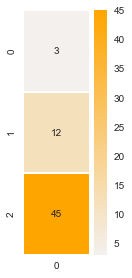

In [3]:
# a single annotation
annotation = [3, 12, 45]  # e.g. Encoder hidden state
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(annotation)), annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

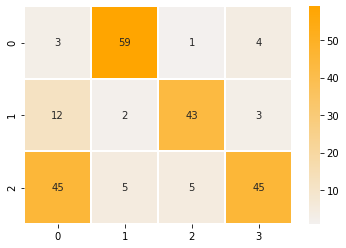

In [5]:
# annotation matrix (each column is an annotation)
annotations = np.transpose([[3,12,45], [59,2,5], [1,43,5], [4,3,45.3]])
ax = sns.heatmap(annotations, annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

## 3. Alignment

The decoder outputs one value at a time, which is passed on to perhaps more layers before finally outputting a prediction (y) for the current output time step.

**The alignment model scores (e) how well each encoded input (h) matches the current output of the decoder (s).**

each encoded h <<<<----match---->>>> the current output of the decoder s

The calculation of the score requires the output from the decoder from the previous output time step, e.g. s(t-1). When scoring the very first output for the decoder, this will be 0.

Scoring is performed using a function a(). We can score each annotation (h) for the first output time step as follows:

- e: alignment model score: the current output of the decoder s <<<<----match---->>>> each encoded h 
- a: score function, as call **alignment model** implemented as a feedforward neural network
- s: the current step encoding

for the first step, previous decoder output is 0
```
e11 = a(0, h1)
e12 = a(0, h2)
e13 = a(0, h3)
```
We use two subscripts for these scores, e.g. e11 where the first “1” represents the output time step, and the second “1” represents the input time step.

We can imagine that if we had a sequence-to-sequence problem with two output time steps, that later we could score the annotations for the second time step as follows (assuming we had already calculated our s1):

```

e21 = a(s1, h1)
e22 = a(s1, h2)
e23 = a(s1, h3)
```

The function a() is called the alignment model in the paper and is implemented as a feedforward neural network.

This is a traditional one layer network where each input (s(t-1) and h1, h2, and h3) is weighted, a hyperbolic tangent (tanh) transfer function is used and the output is also weighted.






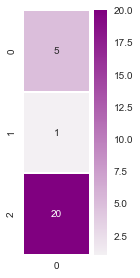

In [30]:
dec_hidden_state = [5, 1, 20] # decoder hidden state
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(dec_hidden_state)), annot=True, cmap=sns.light_palette("purple", as_cmap=True), linewidths=1)

In [31]:
# define the score function a for a single dot product
def single_dot_attention_score(dec_hidden_state, enc_hidden_state):
    # return the dot product of the two vectors
    return np.dot(dec_hidden_state, enc_hidden_state)

In [32]:
# e11 = a(s1, h1)
dec_hidden_state = [5, 1, 20] # s1
single_dot_attention_score(dec_hidden_state, annotation)

927

In [33]:
# define the score function for an annotation matrix
def dot_attention_score(dec_hidden_state, annotations):
    # return the product of dec_hidden_state transpose and enc_hidden_states
    return np.matmul(np.transpose(dec_hidden_state), annotations)

In [34]:
attention_weights_raw = dot_attention_score(dec_hidden_state, annotations)
attention_weights_raw

array([927., 397., 148., 929.])

## 4. Weighting
Next, the alignment scores are normalized using a softmax function.

The normalization of the scores allows them to be treated like probabilities, indicating the likelihood of each encoded input time step (annotation) being relevant to the current output time step.

These normalized scores are called annotation weights.

For example, we can calculate the softmax annotation weights (a) given the calculated alignment scores (e) as follows:

```
a11 = exp(e11) / (exp(e11) + exp(e12) + exp(e13))
a12 = exp(e12) / (exp(e11) + exp(e12) + exp(e13))
a13 = exp(e13) / (exp(e11) + exp(e12) + exp(e13))
```

If we had two output time steps, the annotation weights for the second output time step would be calculated as follows:
```
a21 = exp(e21) / (exp(e21) + exp(e22) + exp(e23))
a22 = exp(e22) / (exp(e21) + exp(e22) + exp(e23))
a23 = exp(e23) / (exp(e21) + exp(e22) + exp(e23))
```


In [35]:
def softmax(x):
    x = np.array(x, dtype=np.float128)
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=0) 

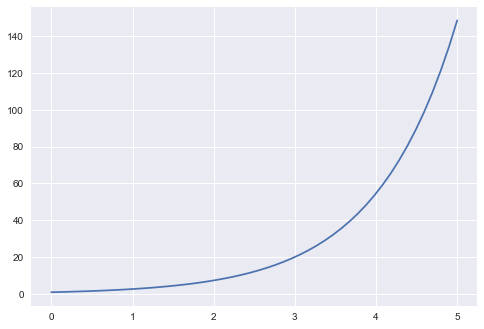

In [39]:
# note the effect e^x natual exponiential function e = 2.71828
fig, ax = plt.subplots()

# numpy.linspace(start, stop, num=50): Return evenly spaced numbers over a specified interval.
x = np.linspace(0, 5, 50) # return 50 numbers between 0 and 10
ax.plot(x, np.exp(x)) # natual exponential function

In [41]:
# The first and last annotation had the respective scores of 927 and 929. But after softmax, the attention they'll get is 0.119 and 0.880 respectively.
attention_weights = softmax(attention_weights_raw)
attention_weights

array([1.19202922e-001, 7.94715151e-232, 5.76614420e-340, 8.80797078e-001],
      dtype=float128)

## 5. Context Vector
Next, each annotation (h) is multiplied by the annotation weights (a) to produce a new attended context vector from which the current output time step can be decoded.

We only have one output time step for simplicity, so we can calculate the single element context vector as follows (with brackets for readability):

```
c1 = (a11 * h1) + (a12 * h2) + (a13 * h3)
```

The context vector is a weighted sum of the annotations and normalized alignment scores.

If we had two output time steps, the context vector would be comprised of two elements [c1, c2], calculated as follows:

```
c1 = a11 * h1 + a12 * h2 + a13 * h3
c2 = a21 * h1 + a22 * h2 + a23 * h3
```

In [43]:
# applying the score back to the annotations
def apply_attention_scores(attention_weights, annotations):
    # Multiple the annotations by their weights
    return attention_weights * annotations

In [44]:
applied_attention = apply_attention_scores(attention_weights, annotations)
applied_attention

array([[3.57608766e-001, 4.68881939e-230, 5.76614420e-340,
        3.52318831e+000],
       [1.43043506e+000, 1.58943030e-231, 2.47944200e-338,
        2.64239123e+000],
       [5.36413149e+000, 3.97357575e-231, 2.88307210e-339,
        3.99001076e+001]], dtype=float128)

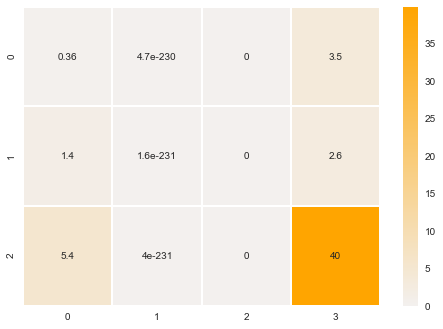

In [45]:
ax = sns.heatmap(applied_attention, annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

Contrast this with the raw annotations visualized earlier in the notebook, and we can see that the second and third annotations (columns) have been nearly wiped out. The first annotation maintains some of its value, and the fourth annotation is the most pronounced.

In [47]:
# All that remains to produce our attention context vector now is to sum up the four columns to produce a single attention context vector
def calculate_attention_vector(applied_attention):
    return np.sum(applied_attention, axis=1)

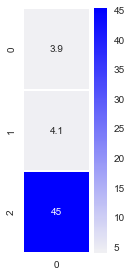

In [48]:
# calculate the context vector
attention_vector = calculate_attention_vector(applied_attention)
attention_vector

# visualization
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(attention_vector)), annot=True, cmap=sns.light_palette("Blue", as_cmap=True), linewidths=1)

## 6. Decode
Decoding is then performed as per the Encoder-Decoder model, although in this case using the attended context vector for the current time step.

The output of the decoder (s) is referred to as a hidden state in the paper.
```
s1 = Decoder(c1)